# Fraud Detection
https://www.kaggle.com/ntnu-testimon/paysim1

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix, roc_curve, roc_auc_score


In [43]:
df1 = pd.read_csv("fraud_detection.csv")

In [44]:
df1.shape

(6362620, 11)

# EDA

In [45]:
df1.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [46]:
df1['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [47]:
pd.crosstab(df1['type'], df1['isFraud'])

isFraud,0,1
type,,
CASH_IN,1399284,0
CASH_OUT,2233384,4116
DEBIT,41432,0
PAYMENT,2151495,0
TRANSFER,528812,4097


Fraudulent activity is coming from cash out and transfers.

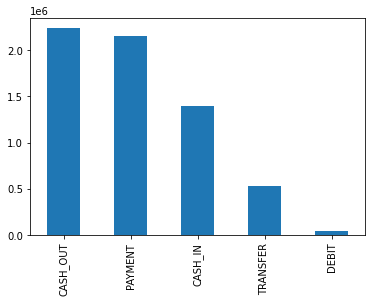

In [48]:
df1.type.value_counts().plot(kind = 'bar')
plt.show()

In [49]:
df1.groupby('type')[['isFraud','isFlaggedFraud']].sum()

,isFraud,isFlaggedFraud
type,,
CASH_IN,0,0
CASH_OUT,4116,0
DEBIT,0,0
PAYMENT,0,0
TRANSFER,4097,16


It seems that isFlaggedFraud is only triggered only if you meet a certain threshold. As you can see, although cashout has 4116 fraud alerts there are none that met the threshold. As for transfers, about 16 met the threshold out of the 4097 that were fraud alerts.

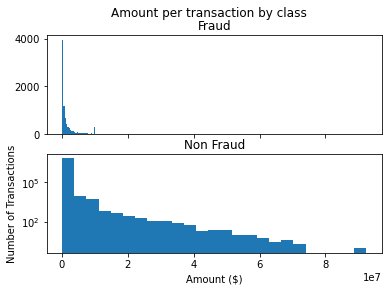

In [50]:
fraud = df1[df1['isFraud']==1]
normal = df1[df1['isFraud']==0]
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 25
ax1.hist(fraud.amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.amount, bins = bins)
ax2.set_title('Non Fraud')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
# plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

The above chart shows that less number of transactions amount in fraud compared to non fraud data.

In [51]:
fraud.head(30)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
251,1,TRANSFER,2806.00,C1420196421,2806.00,0.00,C972765878,0.00,0.00,1,0
252,1,CASH_OUT,2806.00,C2101527076,2806.00,0.00,C1007251739,26202.00,0.00,1,0
680,1,TRANSFER,20128.00,C137533655,20128.00,0.00,C1848415041,0.00,0.00,1,0
681,1,CASH_OUT,20128.00,C1118430673,20128.00,0.00,C339924917,6268.00,12145.85,1,0
724,1,CASH_OUT,416001.33,C749981943,0.00,0.00,C667346055,102.00,9291619.62,1,0
969,1,TRANSFER,1277212.77,C1334405552,1277212.77,0.00,C431687661,0.00,0.00,1,0
970,1,CASH_OUT,1277212.77,C467632528,1277212.77,0.00,C716083600,0.00,2444985.19,1,0
1115,1,TRANSFER,35063.63,C1364127192,35063.63,0.00,C1136419747,0.00,0.00,1,0


# Feature Engineering

In [52]:
def significant_increase(a,b,c, d):
    if a == 0 and (b != 0 or b== 0) and c =="CASH_OUT" and d == 1:
        return "FRAUD ALERT CASH_OUT"
    elif a == 0 and (b != 0 or b == 0) and c == "TRANSFER" and d == 1:
        return "FRAUD ALERT TRANSFER"
    else:
        return "No FRAUD ALERT"

In [53]:
df1['sign_increase'] = np.vectorize(significant_increase)(df1['newbalanceOrig'],df1['newbalanceDest'],df1['type'], df1['isFraud'])

In [54]:
df1.head(50)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,sign_increase
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0,No FRAUD ALERT
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0,No FRAUD ALERT
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0,FRAUD ALERT TRANSFER
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0,FRAUD ALERT CASH_OUT
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0,No FRAUD ALERT
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0,No FRAUD ALERT
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0,No FRAUD ALERT
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0,No FRAUD ALERT
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0,No FRAUD ALERT
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0,No FRAUD ALERT


In [55]:
df1.drop(['nameOrig','nameDest','isFlaggedFraud','type'], axis = 1, inplace = True)

In [56]:
df1.columns

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'sign_increase'],
      dtype='object')

In [57]:
df2 = pd.get_dummies(df1, columns = ['sign_increase'], drop_first = True)

In [58]:
df2.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,sign_increase_FRAUD ALERT TRANSFER,sign_increase_No FRAUD ALERT
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,1
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,1
2,1,181.00,181.0,0.00,0.0,0.0,1,1,0
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,1


In [59]:
df_majority = df2[df2.isFraud == 0]
df_minority = df2[df2.isFraud == 1]


In [60]:
df_minority.shape

(8213, 9)

In [61]:
downsample = resample(df_majority,
                     replace = False,
                      n_samples = 8213,
                      random_state = 1
                     )

df3 = pd.concat([df_minority, downsample])
df3.isFraud.value_counts()

1    8213
0    8213
Name: isFraud, dtype: int64

# Machine Learning

In [95]:
x = df3[df3.drop(['isFraud'], axis = 1).columns].values
y = df3['isFraud'].values

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 0)

In [86]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 2)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

grid_rf = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
grid = RandomizedSearchCV(rf, grid_rf, cv = 5,verbose = True, n_jobs = -1)
grid.fit(x_train,y_train)
params = grid.best_params_
print(params)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.1s finished


{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': False}


In [102]:
rf_grid = RandomForestClassifier(n_estimators = 200, min_samples_split = 5, min_samples_leaf = 1, max_features = 'sqrt',
                                 max_depth = 20, bootstrap = False, random_state = 0)

rf_grid.fit(x_train,y_train)
rf_predictions = rf_grid.predict(x_test)
rf_score = accuracy_score(y_test, rf_predictions)
rf_score*100

100.0

In [119]:
confusion_matrix(y_test, rf_predictions)

array([[1656,    0],
       [   0, 1630]], dtype=int64)

In [104]:
xgb_params = {"learning_rate" : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
              "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
              "min_child_weight" : [ 1, 3, 5, 7 ],
              "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
              "colsample_bytree": [ 0.3, 0.4, 0.5 , 0.7 ] }

xgbooster = xgb.XGBClassifier()
grid_xgb = RandomizedSearchCV(xgbooster, xgb_params, cv = 5, verbose = True, n_jobs = -1)
grid_xgb.fit(x_train,y_train)
params = grid_xgb.best_params_
print(params)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.9s finished


{'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.15, 'gamma': 0.0, 'colsample_bytree': 0.7}


In [108]:
xgbooster_grid = xgb.XGBClassifier(colsample_bytree = 0.7,
                            gamma = 0,
                            learning_rate = 0.15,
                            max_depth = 6,
                            min_child_weight = 5)

xgbooster_grid.fit(x_train, y_train)
xgb_predictions = xgbooster_grid.predict(x_test)
xgb_score = accuracy_score(y_test, xgb_predictions)
xgb_score*100

100.0

In [120]:
confusion_matrix(y_test, xgb_predictions)

array([[1656,    0],
       [   0, 1630]], dtype=int64)

In [111]:
rf_auc = roc_auc_score(y_test,rf_predictions)
xgb_auc = roc_auc_score(y_test, xgb_predictions)

print(f"Random Forest AUCROC : {rf_auc}")
print(f"XGB AUCROC : {xgb_auc}")

Random Forest AUCROC : 1.0
XGB AUCROC : 1.0


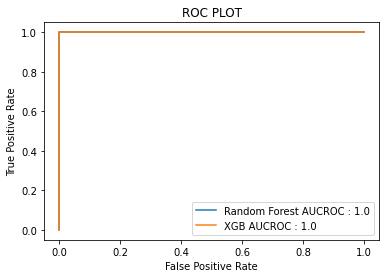

In [137]:


rf_fpr, rf_tpr,_ = roc_curve(y_test, rf_predictions)
xgb_fpr, xgb_tpr,_ = roc_curve(y_test, xgb_predictions)

plt.plot(rf_fpr, rf_tpr, label = f"Random Forest AUCROC : {rf_auc}")
plt.plot(xgb_fpr, xgb_tpr, label = f"XGB AUCROC : {rf_auc}")

plt.title('ROC PLOT')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


As you can see, both curves are at 100%. 